# Advanced Lane Finding Project
The goals / steps of this project are the following:
1. Correct Image Distortion: a) Compute the camera calibration matrix and distortion coefficients given a set of chessboard images, b) Apply a distortion correction to raw images.
2. Use color transforms, gradients, etc., to create a thresholded binary image.
3. Apply a perspective transform to rectify binary image ("birds-eye view").
4. Detect lane pixels and fit to find the lane boundary.
5. Determine the curvature of the lane and vehicle position with respect to center.
6. Warp the detected lane boundaries back onto the original image.
7. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## 1. Correct Image Distortion
Correction of image distortion (created by the camera) is done in 2 steps:
a) calculate cameral matrix and distortion coefficients and
b) undistort an image using statistics calculated in the step a.

The first step was implemented in a utility class src/CameraCallibration.py. The script in aforementioned file processed all provided examples (chessboard images) and stored resulting stats in src/calibration.p. Therefore, in this book we will focus on the step b).

Step b) consists of creating an CameraCalibration object and using this object to undistort an image. The code for this step provided in the cell below.

In [1]:
import cv2
import numpy as np
from src.CameraCalibration import CameraCalibration as CC
from matplotlib import pyplot as plt
from src.utils import visualize_planes
%matplotlib inline
# Create camera calibration object
calibration_file = "src/calibration.p"
cc = CC(calibration_file)
# Read and undistort an image
test_img_path1 = "test_images/straight_lines2.jpg"
test_img_path2 = "test_images/test3.jpg"
test_img1 = cv2.cvtColor(cv2.imread(test_img_path1), cv2.COLOR_BGR2RGB)
test_img2 = cv2.cvtColor(cv2.imread(test_img_path2), cv2.COLOR_BGR2RGB)
undistorted_img1 = cc.undistort(test_img1, 1)
undistorted_img2 = cc.undistort(test_img2, 1)
undistorted_cropped_img1 = cc.undistort(test_img1)
undistorted_cropped_img2 = cc.undistort(test_img2)

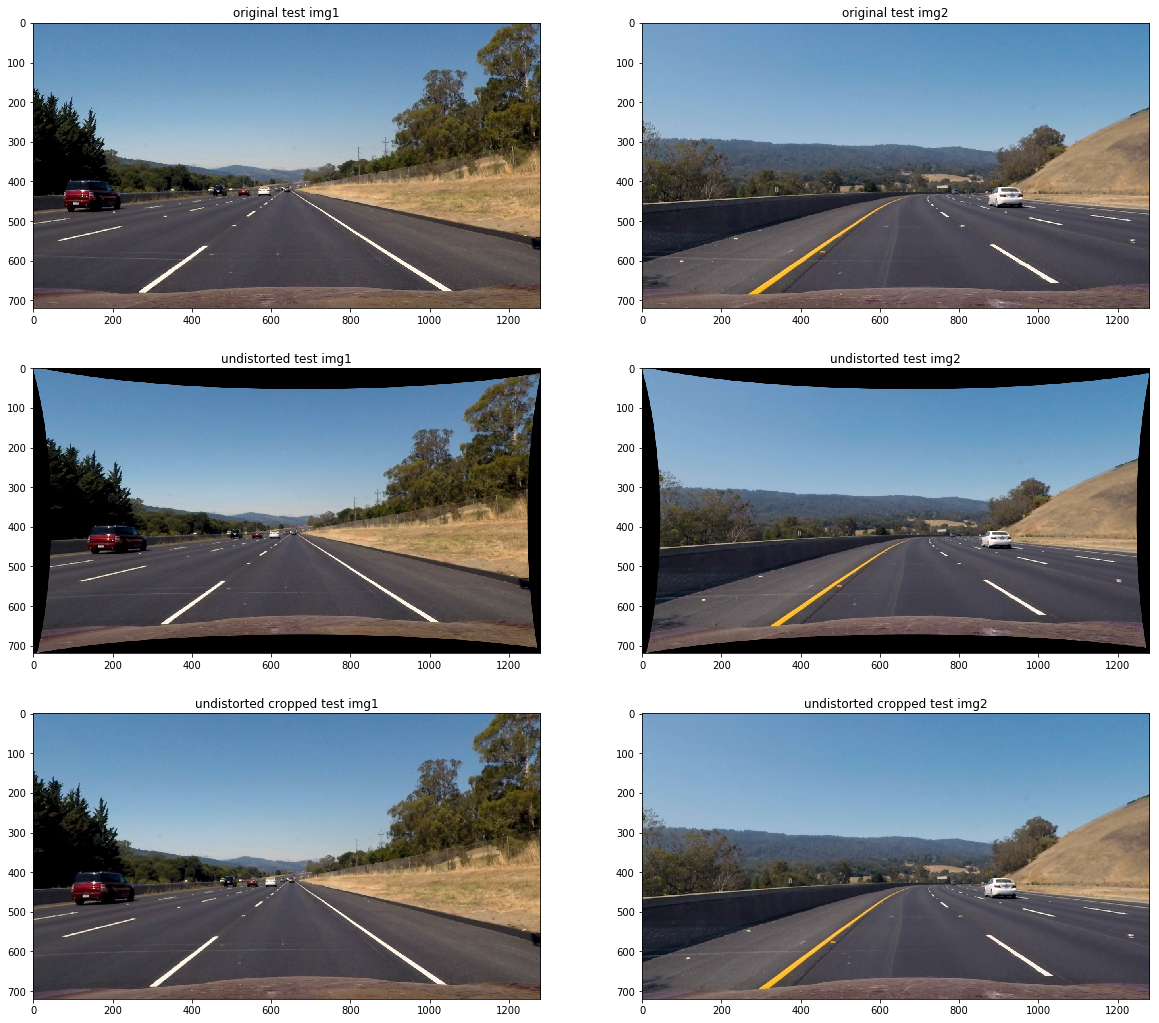

In [2]:
# Visualize resulting images
f, p = plt.subplots(3, 2, figsize=[20,18])
p[0][0].set_title("original test img1")
p[0][0].imshow(test_img1)
p[1][0].set_title("undistorted test img1")
p[1][0].imshow(undistorted_img1)
p[2][0].set_title("undistorted cropped test img1")
p[2][0].imshow(undistorted_cropped_img1)
p[0][1].set_title("original test img2")
p[0][1].imshow(test_img2)
p[1][1].set_title("undistorted test img2")
p[1][1].imshow(undistorted_img2)
p[2][1].set_title("undistorted cropped test img2")
p[2][1].imshow(undistorted_cropped_img2)

## 2. Use color transforms, gradients, etc., to create a thresholded binary image
Second step includes a raw image transformation into a binary masks by applying conditions to processed image. The image processing step relies on the conversion of the raw image into either a combination of x and y Sobel gradients or using a particular color channel or combination of all.

The code below presents functions allowing to conver your raw images into binary masks.

In [3]:
from src.utils import abs_sobel_thresh, mag_thresh, dir_threshold

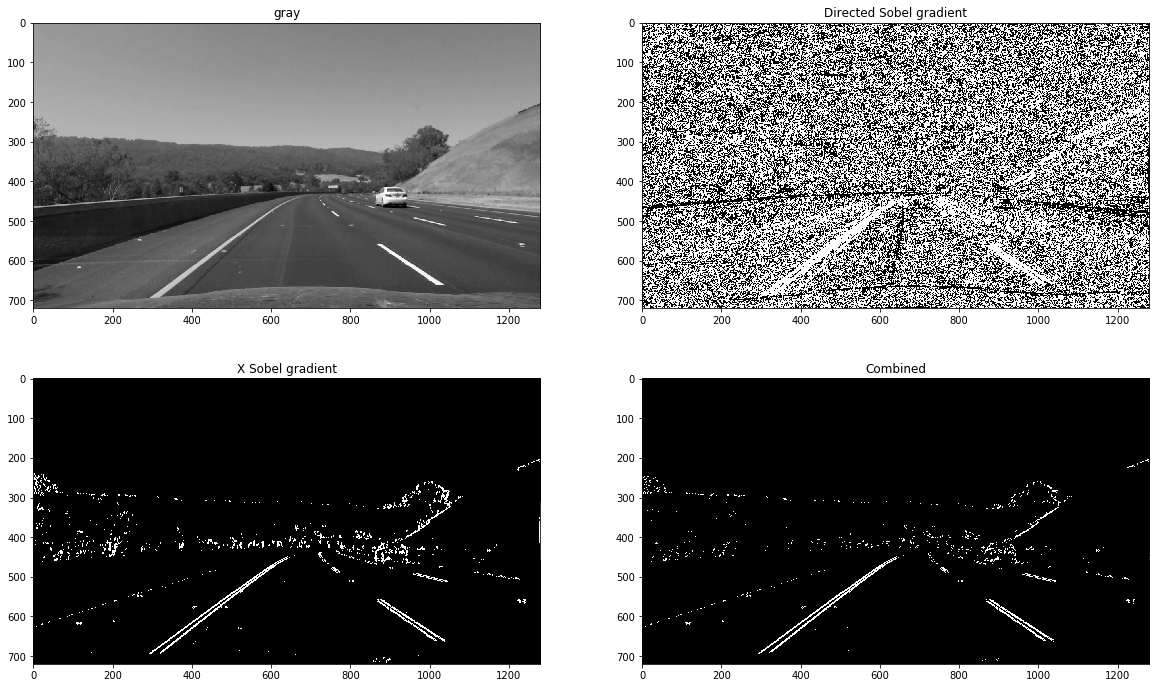

In [4]:
# Convert to grayscale
gray = cv2.cvtColor(undistorted_cropped_img2, cv2.COLOR_RGB2GRAY)
# Transform and visualize images
sobel_x_img = abs_sobel_thresh(gray, orient='x', kernel=7, thresh=(30, 150))
direct_sobel_img = dir_threshold(gray, kernel=7, thresh=(30*np.pi/180, 80*np.pi/180))
combined = np.zeros_like(sobel_x_img, dtype=np.uint8)
combined[(sobel_x_img==1) & (direct_sobel_img==1)] = 1
f, p = plt.subplots(2,2, figsize=[20, 12])
p[0,0].set_title("gray")
p[0,0].imshow(gray, cmap='gray')
p[1,0].set_title("X Sobel gradient")
p[1,0].imshow(sobel_x_img, cmap='gray')
p[0,1].set_title("Directed Sobel gradient")
p[0,1].imshow(direct_sobel_img, cmap='gray')
p[1,1].set_title("Combined")
p[1,1].imshow(combined, cmap='gray')

Based to the results presented above, Sobel gradient with x orientation is a good starting point. However, additional condition set for the direction of the gradient helps to remove some of the noice from the middel part of the image.

Out current approach relies on gray scale image and doesn't use color information. Color information, however, can help to further improve our solution. In order to capture color information, I will convert raw image into hsl image to validate which of the channels provies the best features for lane detection.

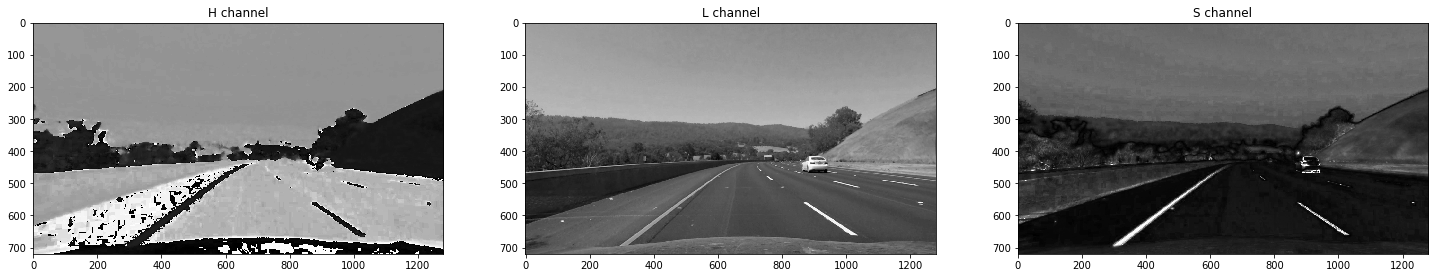

In [5]:
img = undistorted_cropped_img2
HLS_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
h, l, s = HLS_img[:,:,0], HLS_img[:,:,1], HLS_img[:,:,2]
f, p = plt.subplots(1,3, figsize=[25, 8])
p[0].set_title("H channel")
p[0].imshow(h, cmap="gray")
p[1].set_title("L channel")
p[1].imshow(l, cmap="gray")
p[2].set_title("S channel")
p[2].imshow(s, cmap="gray")

S (saturation) channel seem to separate lanes well. However, if you look closely to the top side of the righ lane, you can see that it is not registered. Therefore, a combination of gray scale image and sobel(x) gradient would be a better fit for the goal.

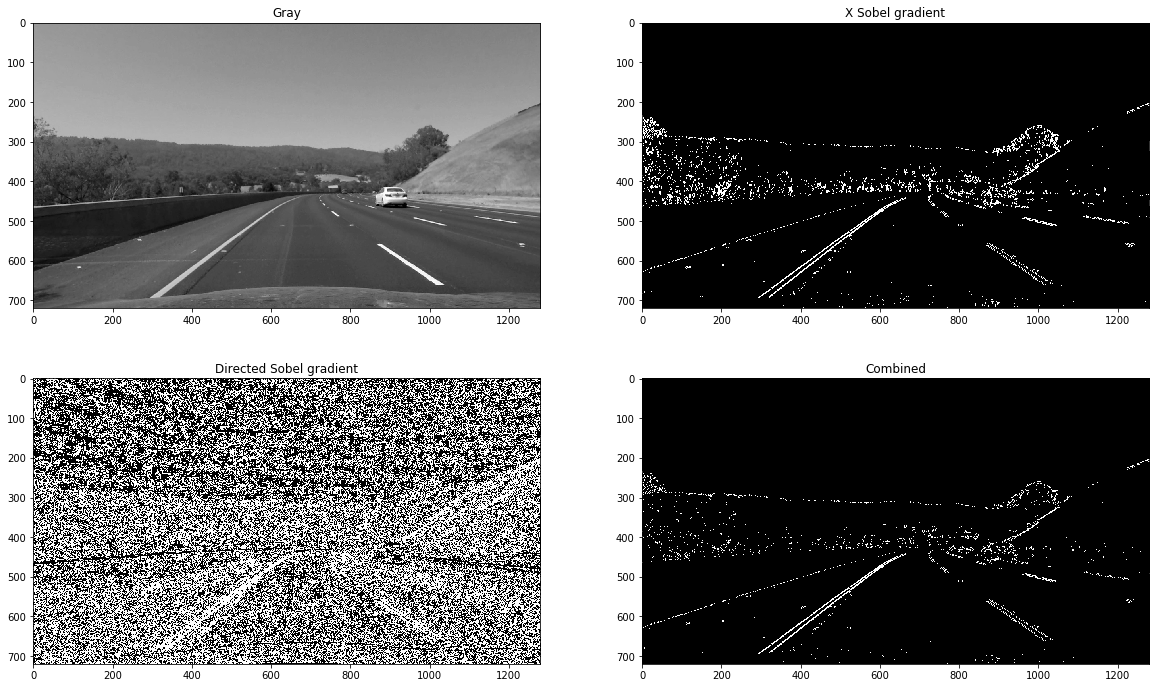

In [6]:
# Transform and visualize images
sobel_x_img = abs_sobel_thresh(gray, kernel=3, thresh=(20, 100))
direct_sobel_img = dir_threshold(gray, kernel=3, thresh=(30*np.pi/180, 80*np.pi/180))
combined = np.zeros_like(sobel_x_img, dtype=np.uint8)
combined[(sobel_x_img==1) & (direct_sobel_img==1)] = 1
f, p = plt.subplots(2,2, figsize=[20, 12])
p[0,0].set_title("Gray")
p[0,0].imshow(gray, cmap='gray')
p[0,1].set_title("X Sobel gradient")
p[0,1].imshow(sobel_x_img, cmap='gray')
p[1,0].set_title("Directed Sobel gradient")
p[1,0].imshow(direct_sobel_img, cmap='gray')
p[1,1].set_title("Combined")
p[1,1].imshow(combined, cmap='gray')

## 3. Apply a perspective transform to rectify binary image ("birds-eye view").

To apply a perspective transform I first calculated the coordinates for rectangle that describes the plane on a source (src) and desired image (dst). Then, I created a transformation matrix (cv2.getPerspectiveTransform) and applied this matrix to the image (cv2.warpPerspective).

The transformation script and result of the transformation are presented below:

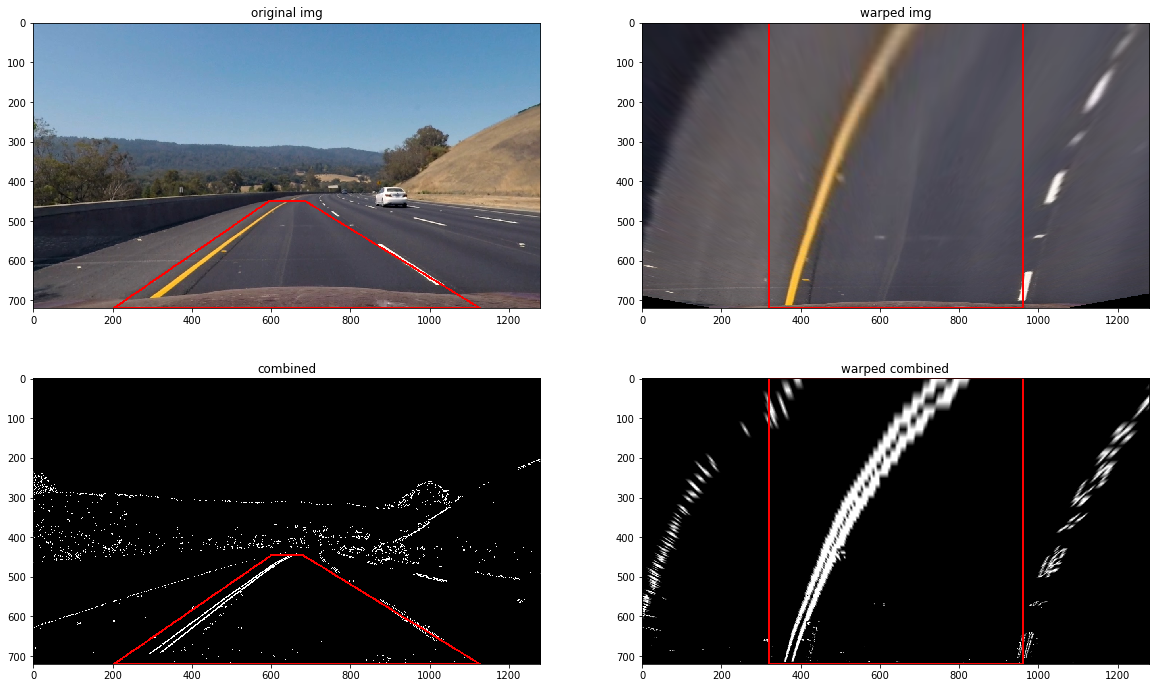

In [8]:
from src.utils import warper

top_c_shift = 39
top_v_shift = 85

rgb_combined = np.dstack([combined, combined, combined])*255
warped_combined, (src, dst) = warper(rgb_combined, top_c_shift=top_c_shift, top_v_shift=top_v_shift)
rgb_combined = visualize_planes(rgb_combined, src)
warped_combined = visualize_planes(warped_combined, dst)
warped_img, (src, dst) = warper(img)
undistorted_cropped_img2 = visualize_planes(undistorted_cropped_img2, src)
warped_img = visualize_planes(warped_img, dst)

fig, p = plt.subplots(2,2, figsize=[20,12])
p[0,0].set_title("original img")
p[0,0].imshow(img)
p[0,1].set_title("warped img")
p[0,1].imshow(warped_img)
p[1,0].set_title("combined")
p[1,0].imshow(rgb_combined)
p[1,1].set_title("warped combined")
p[1,1].imshow(warped_combined)

## 4. Detect lane pixels and fit to find the lane boundary

In order to detect lane pixels I applied a sliding window method. Sliding window method divides the images into n windows. The maximum activations found in each window considered to be the centers of the lane or centorid. Therefore, binary active pixels sournding this centroid will be considered belonging to the lane.

The method of finding centroids described in map_window method of src/utils.py

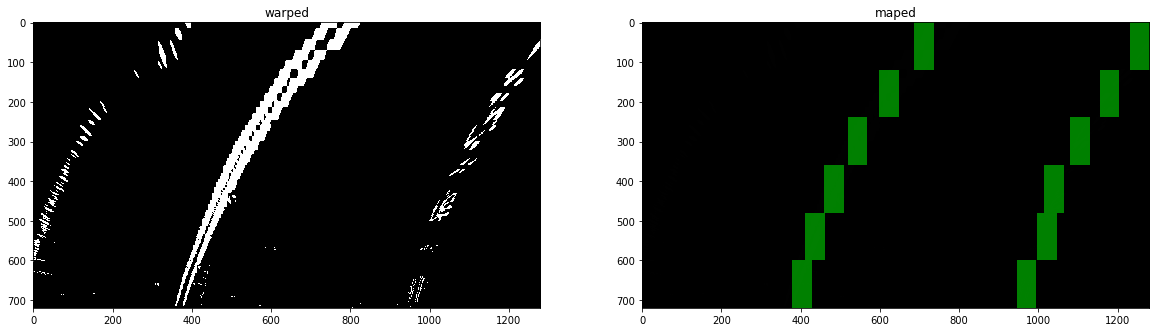

In [11]:
from src.utils import map_window
warped_combined, _ = warper(combined, top_c_shift=top_c_shift, top_v_shift=top_v_shift)
mapped_binary, centroids = map_window(warped_combined, 50, 120, 100)
# Display the final results
fig, p = plt.subplots(1, 2, figsize=[20, 6])
p[0].set_title("warped")
p[0].imshow(warped_combined, cmap="gray")
p[1].set_title("maped")
p[1].imshow(mapped_binary)

## 5. Determine the curvature of the lane and vehicle position with respect to center.

To calculate the curvature I applied the formula below:

R(f(y)) = (1+f(y)'^2)^(2/3) / |f(y)''|, where:

* f(y) = A*y^2 + B*y + C
* f(y)' = 2Ay + B
* f(y)'' = 2A

Therefore:

R(f(y)) = (1+(2Ay+B)^2)^(2/3) / |2A|

The results are presented below:

In [12]:
from src.utils import fit_polynomial, plot_2nd_degree_polynomial

R = lambda M, y: (1+(2*M[0]*y+M[1])**2)**(2/3) / np.abs(2*M[0])

x_scaller = 3.7 / 580
y_scaller = 8.5*3 / 720

left_x, left_y = plot_2nd_degree_polynomial(centroids[:, 0], mapped_binary.shape[0])
right_x, right_y = plot_2nd_degree_polynomial(centroids[:, 1], mapped_binary.shape[0])

left_fit = fit_polynomial(centroids[:, 0], mapped_binary.shape[0], x_scaller=x_scaller, y_scaller=y_scaller)
right_fit = fit_polynomial(centroids[:, 1], mapped_binary.shape[0], x_scaller=x_scaller, y_scaller=y_scaller)

left_curve_rad = R(left_fit, left_y).mean()
right_curve_rad = R(right_fit, right_y).mean()

print("Left radius in meters: {:.1f}".format(left_curve_rad))
print("Right radius in meters: {:.1f}".format(right_curve_rad))

Left radius in meters: 546.2
Right radius in meters: 564.5
